In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
%matplotlib inline
# import stats as sts 

In [2]:
#read analyst actuals file
column_names1 = ['TICKER','ANNDATS','quarternum','earn_value']
df_actual_ern=pd.read_csv("../AFE_data/df_actual_ern.csv", header = None, names = column_names1)
#df_actual_ern = pd.read_csv('/Users/Blair/Downloads/AFE_data/df_actual_ern.csv')
#read analyst forecast file
column_names2 = ['TICKER','ANNDATS','quarternum','analyst','forecast_value']
df_aforcast=pd.read_csv("../AFE_data/df_aforecast.csv", header = None, names = column_names2)
#df_aforecast = pd.read_csv('/Users/Blair/Downloads/AFE_data/df_aforecast.csv')

In [3]:
#Set Year
df_actual_ern['year'] = df_actual_ern['ANNDATS'].apply(lambda x: str(x)[:4])

df_aforcast['year'] = df_aforcast['ANNDATS'].apply(lambda x: str(x)[:4])

In [4]:
#Merge two datasets
merged = pd.merge(df_aforcast,df_actual_ern,how = 'inner', on = ['TICKER','quarternum','year'])
merged.head()

,TICKER,ANNDATS_x,quarternum,analyst,forecast_value,year,ANNDATS_y,earn_value
0,AA,19961231,3,3700,4.3125,1996,19961004,0.5775
1,AA,19961231,3,281,4.1250,1996,19961004,0.5775
2,AA,19961231,3,4088,3.1875,1996,19961004,0.5775
3,AA,19971231,3,662,3.0000,1997,19971006,0.9375
4,AA,19971231,3,472,3.9375,1997,19971006,0.9375


In [5]:
x = (merged['forecast_value']/merged['earn_value']).dropna()
x[abs(x)<500].mean()


3.9040134873693755

In [6]:
#Surprise Matrics
merged.index = merged[['TICKER', 'year','quarternum']]

df=merged.reset_index()
merged['meadian']=df.groupby('index').forecast_value.median()
merged['mean']=df.groupby('index').forecast_value.mean()
merged['std']=df.groupby('index').forecast_value.std()
merged['delta_mm']=merged['meadian']-merged['mean']

In [7]:
#Median forecast - actual
merged['surprise_median_fa']=(merged['earn_value']-merged['meadian']*.25)/merged['std']
#Mean forecast - actual
merged['surprise_mean_fa']=(merged['earn_value']-merged['mean']*.25)/merged['std']

In [8]:
merged_cleaned = merged[merged['std']>0]


print('with 0 std',merged.shape)
print('0 std removed',merged_cleaned.shape)


with 0 std (69965, 14)
0 std removed (68714, 14)


In [9]:
#the skewness of the distribution:median_mean
merged_cleaned['skew']=merged_cleaned['delta_mm']/merged_cleaned['delta_mm'].std()
#the kurtosis of the distribution


/home/jasonmellone/anaconda2/envs/py3dsqf/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


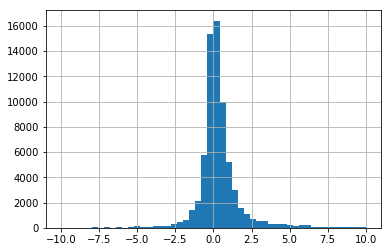

In [10]:
merged_cleaned[abs(merged_cleaned.surprise_median_fa)<10]['surprise_median_fa'].hist(bins=50)

In [11]:
merged_cleaned['kurtosis_mean']=merged_cleaned['surprise_mean_fa'].kurt()
merged_cleaned['kurtosis_median']=merged_cleaned['surprise_median_fa'].kurt()

/home/jasonmellone/anaconda2/envs/py3dsqf/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jasonmellone/anaconda2/envs/py3dsqf/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


●	How do your pre-post earnings price time series from the previous section look as a function of conditioning on different values of the surprise metrics (and distribution metrics) above?

In [59]:
price_distributions = pd.read_csv('../AFE_data/df_prc_dist.csv')
del price_distributions['Unnamed: 0']
del price_distributions['quarternum']

In [60]:
price_distributions['year'] = price_distributions['ANNDATS'].apply(lambda x: str(x)[:4])

In [61]:
qs,bins = pd.qcut(merged_cleaned['surprise_mean_fa'],10,retbins=True)

In [62]:
quantile_dfs = []
for i in range(0,len(bins)-1):
    print(i,bins[i],bins[i+1])
    
    quantile_filtered_earnings = merged_cleaned[(merged_cleaned['surprise_mean_fa']>=bins[i])& (merged_cleaned['surprise_mean_fa']<bins[i+1])].copy()
    quantile_filtered_earnings = quantile_filtered_earnings[['TICKER','year']].drop_duplicates()
    
    price_drift_df = pd.merge(quantile_filtered_earnings,price_distributions,on=['TICKER','year'])
    
    df = price_drift_df[list(map(str,list(range(-30,31,1))))].mean().copy()
    df.name = 'quantile_' + str(i)
    quantile_dfs.append(df)
    

0 -287.438906552 -0.700018898449
1 -0.700018898449 -0.327163183558
2 -0.327163183558 -0.130452862091
3 -0.130452862091 0.0254204932967
4 0.0254204932967 0.164936710639
5 0.164936710639 0.344256557174
6 0.344256557174 0.567454275478
7 0.567454275478 0.883183043048
8 0.883183043048 1.64225312845
9 1.64225312845 188.50486289


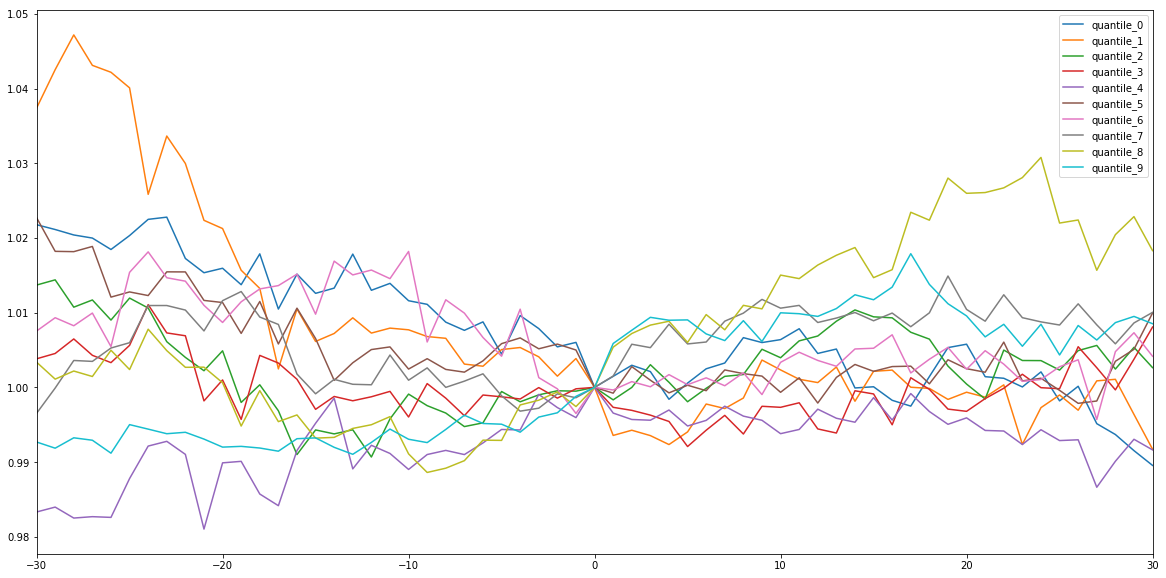

In [64]:
df = pd.concat(quantile_dfs,axis=1)
df.index = list(map(float,df.index))
(df).plot(figsize=[20,10])

In [76]:
df.iloc[-61]

quantile_0    1.021778
quantile_1    1.037388
quantile_2    1.013698
quantile_3    1.003823
quantile_4    0.983314
quantile_5    1.022720
quantile_6    1.007540
quantile_7    0.996523
quantile_8    1.003373
quantile_9    0.992683
Name: -30.0, dtype: float64

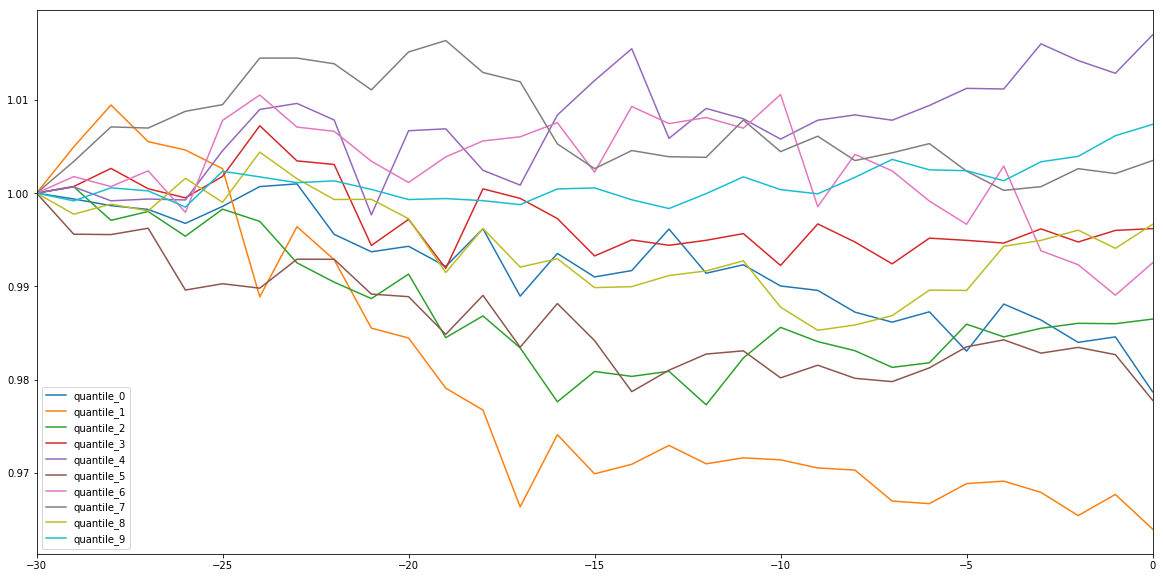

In [77]:
(df[df.index<=0]/df.iloc[-61]).plot(figsize=[20,10])

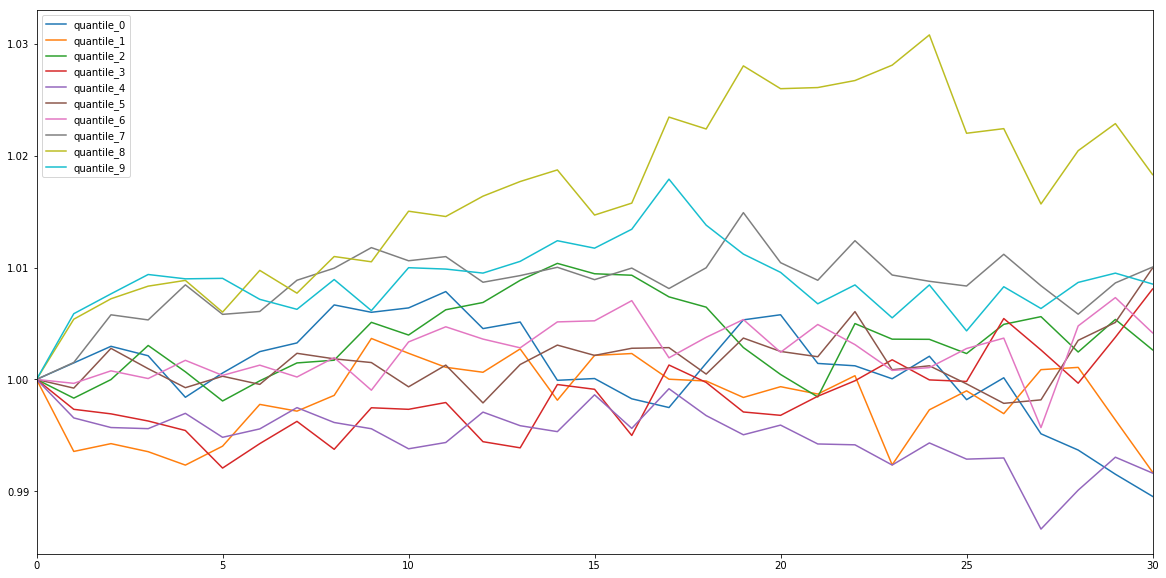

In [78]:
(df[df.index>=0]).plot(figsize=[20,10])